<a href="https://colab.research.google.com/github/tfrizza/DALL-E-tf/blob/main/tfFlowers_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q tensorflow_addons

     |████████████████████████████████| 706kB 6.4MB/s 


In [2]:
!git clone https://github.com/tfrizza/DALL-E-tf.git

Cloning into 'DALL-E-tf'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 75 (delta 39), reused 38 (delta 16), pack-reused 0
Unpacking objects: 100% (75/75), done.


In [3]:
%cd DALL-E-tf

/content/DALL-E-tf


In [45]:
import tensorflow as tf
from tensorflow.keras import Model, mixed_precision
from tensorflow.keras.losses import Loss, MeanSquaredError, MeanAbsoluteError, MSE, MAE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.callbacks import Callback

import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import layers as tfpl

import tensorflow_datasets as tfds
from tensorflow_addons.optimizers import LAMB, AdamW

from dall_e_tf.encoder import dvae_encoder
from dall_e_tf.decoder import dvae_decoder
from dall_e_tf.vae import dVAE
from dall_e_tf.losses import LatentLoss
from dall_e_tf.utils import plot_reconstructions

import numpy as np
import attr
from functools import partial

mixed_precision.set_global_policy('float32')
AUTOTUNE = tf.data.AUTOTUNE

In [16]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.TPUStrategy(tpu)
NUM_DEVICES = strategy.num_replicas_in_sync
print("REPLICAS: ", NUM_DEVICES)

Running on TPU  ['10.51.112.18:8470']


INFO:tensorflow:Initializing the TPU system: grpc://10.51.112.18:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.51.112.18:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [38]:
def crop(image):
    y_nonzero, x_nonzero, _ = tf.experimental.numpy.nonzero(image)
    return image[tf.reduce_min(y_nonzero):tf.reduce_max(y_nonzero), tf.reduce_min(x_nonzero):tf.reduce_max(x_nonzero)]

def preprocess(data, h=128, w=128):
    img = crop(data['image'])
    img = tf.image.resize(img, size=(h,w), antialias=False)
    img /= 255
    return img

GLOBAL_BATCH_SIZE = 16 * NUM_DEVICES

train_dataset = tfds.load('tf_flowers', 
                            split='train', 
                            shuffle_files=True,
                            try_gcs=True
                          )
train_dataset = train_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)\
                             .batch(GLOBAL_BATCH_SIZE)\
                             .prefetch(buffer_size=AUTOTUNE)

train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)
train_dataset

<PrefetchDataset shapes: (None, 128, 128, 3), types: tf.float32>

In [39]:
class LatentLoss(Loss):

    def call(self, dummy_ground_truth, outputs):
        del dummy_ground_truth
        z_e, z_q = tf.split(outputs, 2, axis=-1)
        vq_loss = tf.reduce_mean(tf.square(tf.stop_gradient(z_e) - z_q))
        commit_loss = tf.reduce_mean(tf.square(z_e - tf.stop_gradient(z_q)))
        return vq_loss + 1.0 * commit_loss

In [40]:
from tensorflow.python.keras import backend as K
from tensorflow.python.framework import ops

class TemperatureScheduler(Callback):
    def __init__(self, schedule, layer_name='gumbel-softmax', verbose=0):
        super(TemperatureScheduler, self).__init__()
        self.schedule = schedule
        self.layer_name = layer_name
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        layer = self.model.get_layer(self.layer_name)
        if not hasattr(layer, '_most_recently_built_distribution'):
            raise ValueError('Layer must have a "_most_recently_built_distribution" attribute.')
        distrib = layer._most_recently_built_distribution
        if not hasattr(distrib, 'temperature'):
            raise ValueError('Distribution must have a "temperature" attribute.')
        # T = float(K.get_value(distrib.temperature))
        # T = distrib.temperature
        T = self.schedule(epoch)
        if not isinstance(T, (ops.Tensor, float, np.float32, np.float64)):
            raise ValueError('The output of the "schedule" function '
                            'should be float.')
        if isinstance(T, ops.Tensor) and not T.dtype.is_floating:
            raise ValueError('The dtype of Tensor should be float')
        K.set_value(distrib.temperature, K.get_value(T))
        if self.verbose > 0:
            print('\nEpoch %05d: TemperatureScheduler reducing temperature '
                'rate to %s.' % (epoch + 1, T))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        T = self.model.get_layer(self.layer_name)._most_recently_built_distribution.temperature
        logs['temperature'] = K.get_value(T)

In [48]:
vocab_size = 8192//8
n_hid = 256//4

# def dVAE(enc, dec):
#     z_e = enc.output # encoder logits
#     temperature = tf.keras.layers.Input((1,))

#     z_q = tfpl.DistributionLambda(
#         lambda x: tfd.RelaxedOneHotCategorical(temperature=x[0], logits=x[1]) # Gumbel-softmax
#         , name='gumbel-softmax'
#     )([temperature, z_e])

#     z_hard = tf.math.argmax(z_e, axis=-1) # non-differentiable
#     z_hard = tf.one_hot(z_hard, enc.output.shape[-1], dtype=z_q.dtype)

#     z = z_q + tf.stop_gradient(z_hard - z_q) # straight-through Gumbel-softmax
#     x_rec = dec(z)
#     latents = tf.stack([z_hard, z_q], -1, name='latent')
#     return Model([enc.input, temperature], [x_rec, latents])

class dVAE(Model):
    def __init__(self, enc, dec, initial_temp=1.0, temp_decay=0.9):
        super().__init__()
        self.enc = enc
        self.dec = dec
        self.temperature = initial_temp
        self.temp_decay = temp_decay

        self.gumbel_softmax = tfpl.DistributionLambda(
            lambda x: tfd.RelaxedOneHotCategorical(temperature=x[0], logits=x[1]) # Gumbel-softmax
            , name='gumbel-softmax'
        )

    def call(self, x, training=False):
        z_e = self.enc(x)
        z_q = self.gumbel_softmax([self.temperature, z_e])

        z_hard = tf.math.argmax(z_e, axis=-1) # non-differentiable
        z_hard = tf.one_hot(z_hard, enc.output.shape[-1], dtype=z_q.dtype)

        z = z_q + tf.stop_gradient(z_hard - z_q) # straight-through Gumbel-softmax
        x_rec = self.dec(z)
        latents = tf.stack([z_hard, z_q], -1, name='latent')
        return x_rec, latents
    
    def train_step(self, x):
        with tf.GradientTape() as tape:
            x_pred, latents = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(x, x_pred, regularization_losses=self.losses)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(x, x_pred)
        # Decay the GS temperature
        self.temperature *= self.temp_decay
        return {m.name: m.result() for m in self.metrics}

with strategy.scope():
    enc = dvae_encoder(group_count=4, n_hid=n_hid, n_blk_per_group=2, input_channels=3, vocab_size=vocab_size, activation='swish')
    dec = dvae_decoder(group_count=4, n_init=n_hid//2, n_hid=n_hid, n_blk_per_group=2, output_channels=3, vocab_size=vocab_size, activation='swish')

    vae = dVAE(enc, dec)

    epochs = 1000
    temp_schedule = PolynomialDecay(1.0, epochs, 1/16, 8) # quadratic decay
    lr_schedule = PolynomialDecay(1e-3, epochs, 1e-4, 0.5) # sqrt decay
    optimizer = AdamW(weight_decay=1e-4, learning_rate=lr_schedule)

    def psnr(x1, x2):
        return tf.image.psnr(x1, x2, max_val=1.0)
    vae.compile(loss=['mse', None], optimizer=optimizer, metrics=[psnr])
    
    # loss_fn = MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
    # def compute_loss(labels, predictions):
    #     per_example_loss = loss_fn(labels, predictions)
    #     return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)
epoch = 0
vae.build(input_shape=(128,128,128,3))
vae.summary(line_length=200)

Model: "d_vae_8"
________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                                              Output Shape                                                                    Param #                       
model_28 (Functional)                                                                     (None, None, None, 1024)                                                        2848160                       
________________________________________________________________________________________________________________________________________________________________________________________________________
model_29 (Functional)                                                                     (None, None, None, 3)                                                           2709955  

In [ ]:
vae.fit(train_dataset,
        # validation_data=x_test,
        # steps_per_epoch=10,
        epochs=1000,
        # batch_size=32,
        # shuffle=True,
        # callbacks=callbacks
        )

Epoch 1/1000
29/29 [==============================] - 56s 210ms/step - loss: 0.0842 - psnr: 11.0988
Epoch 2/1000
29/29 [==============================] - 6s 212ms/step - loss: 0.0786 - psnr: 11.3987
Epoch 3/1000
29/29 [==============================] - 6s 211ms/step - loss: 0.0580 - psnr: 12.7731
Epoch 4/1000
29/29 [==============================] - 6s 212ms/step - loss: 0.0474 - psnr: 13.6399
Epoch 5/1000
29/29 [==============================] - 6s 211ms/step - loss: 0.0450 - psnr: 13.8724
Epoch 6/1000
29/29 [==============================] - 6s 214ms/step - loss: 0.0435 - psnr: 14.0297
Epoch 7/1000
29/29 [==============================] - 6s 211ms/step - loss: 0.0470 - psnr: 13.6324
Epoch 8/1000
29/29 [==============================] - 6s 214ms/step - loss: 0.0422 - psnr: 14.1111
Epoch 9/1000
29/29 [==============================] - 6s 213ms/step - loss: 0.0331 - psnr: 15.1887
Epoch 10/1000
29/29 [==============================] - 6s 210ms/step - loss: 0.0303 - psnr: 15.5629
Epoch 11

In [21]:
def train_step(x, T):
    with tf.GradientTape() as tape:
        y_pred, latents = vae([x, T], training=True)
        loss = compute_loss(x, y_pred)
    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))
    return loss 

@tf.function
def distributed_train_step(x, T):
  per_replica_losses = strategy.run(train_step, args=(x, T))
  return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses,
                         axis=None)

while epoch < epochs:
    print(f'\nEpoch {epoch+1}/{epochs}')
    progbar = tf.keras.utils.Progbar(None, interval=0.5, stateful_metrics=['loss','temp'])
    temperature = temp_schedule(epoch)
    for i, (x_batch_train, _) in enumerate(train_dist_dataset):
        loss = distributed_train_step(x_batch_train, temperature)
        progbar.add(GLOBAL_BATCH_SIZE, values=[('loss',loss),('temp',temperature)])
    epoch += 1


Epoch 1/1000


   3584/Unknown - 85s 24ms/step - loss: 879.0842 - temp: 1.0000 WARNING:tensorflow:Model was constructed with shape (None, 1) for input KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='input_12'), name='input_12', description="created by layer 'input_12'"), but it was called on an input with incompatible shape ().


   3712/Unknown - 98s 26ms/step - loss: 663.9417 - temp: 1.0000
Epoch 2/1000
   3712/Unknown - 16s 4ms/step - loss: 506.9431 - temp: 0.9925
Epoch 3/1000
   3712/Unknown - 16s 4ms/step - loss: 422.0652 - temp: 0.9851
Epoch 4/1000
   3712/Unknown - 16s 4ms/step - loss: 295.7702 - temp: 0.9777
Epoch 5/1000
   3712/Unknown - 16s 4ms/step - loss: 277.1426 - temp: 0.9704
Epoch 6/1000
   3712/Unknown - 16s 4ms/step - loss: 285.8583 - temp: 0.9631
Epoch 7/1000
   3712/Unknown - 16s 4ms/step - loss: 259.2644 - temp: 0.9559
Epoch 8/1000
   3712/Unknown - 16s 4ms/step - loss: 242.9737 - temp: 0.9488
Epoch 9/1000
   3712/Unknown - 16s 4ms/step - loss: 235.4194 - temp: 0.9417
Epoch 10/1000
   3712/Unknown - 16s 4ms/step - loss: 251.7340 - temp: 0.9346
Epoch 11/1000
   3712/Unknown - 16s 4ms/step - loss: 256.9468 - temp: 0.9276
Epoch 12/1000
   3712/Unknown - 16s 4ms/step - loss: 229.6311 - temp: 0.9206
Epoch 13/1000
   3712/Unknown - 16s 4ms/step - loss: 240.6671 - temp: 0.9137
Epoch 14/1000
   371

KeyboardInterrupt: ignored

In [ ]:
vae.fit(train_dataset,
        # validation_data=(x_test, x_test),
        # steps_per_epoch=10,
        epochs=1000,
        # batch_size=32,
        # shuffle=True,
        callbacks=callbacks
        )

1. Size: 1.00G
     Operator: op_type="ResizeNearestNeighbor" op_name="while/body/_1/while/model_23/model_22/up_sampling2d_23/resize/ResizeNearestNeighbor"
     Shape: f32[32,128,128,512]{3,0,2,1:T(8,128)}
     Unpadded size: 1.00G
     XLA label: %custom-call.6 = f32[32,128,128,512]{3,0,2,1:T(8,128)} custom-call(f32[32,64,64,512]{3,0,2,1:T(8,128)} %fusion.827), custom_call_target="ResizeNearest", metadata={op_type="ResizeNearestNeighbor" op_name="while/body/_1/while/model_23/model_22/up_sampling2d_...
     Allocation type: HLO temp
     ==========================

  2. Size: 512.00M
     Operator: op_type="MaxPoolGrad" op_name="while/body/_1/gradient_tape/while/model_23/max_pooling2d_21/MaxPool/MaxPoolGrad"
     Shape: f32[32,128,128,256]{3,0,2,1:T(8,128)}
     Unpadded size: 512.00M
     XLA label: %select-and-scatter.2.remat2 = f32[32,128,128,256]{3,0,2,1:T(8,128)} select-and-scatter(f32[32,128,128,256]{3,0,2,1:T(8,128)} %fusion.687.remat3, f32[32,64,64,256]{3,0,2,1:T(8,128)} %fusion.773, f32[]{:T(256)} %constant.3), window={size=1x2x2x1 stride=1x2x...
     Allocation type: HLO temp
     ==========================

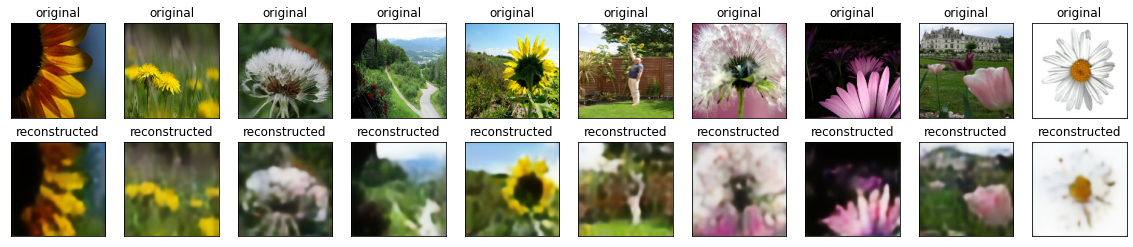

In [22]:
train_batch = next(iter(train_dataset))[0]
plot_reconstructions(vae([train_batch[:10],1.0])[0], train_batch[:10])